# Analysis

## Setup

In [1]:
############################################################################################################################ 
# Get the latest CREST files for each ID within the target folder (dirname)

from pathlib import Path
import json
from sqlite3 import connect as sqlite3_connect
from sqlite3 import DatabaseError
from igraph import Graph as ig_Graph
from igraph import plot as ig_plot
from scipy.spatial.distance import cdist
from random import choice as random_choice
from itertools import combinations
from numpy import array, unravel_index, argmin, mean
import numpy as np
from copy import deepcopy
import itertools
from datetime import datetime
from time import time
import neuroglancer
from webbrowser import open as wb_open
from webbrowser import open_new as wb_open_new
import pandas as pd

from eCREST_cli import ecrest, import_settings

The 'ecrest' class has been imported from eCREST_cli.py

An instance of this object will be able to:
- open an neuroglancer viewer for proofrieading (see "Proofread using CREST")
    - add-remove segments (using graph feature for efficiency)
    - format itself and save itself as a CREST-style .json
- convert from neuroglancer json (see "Convert From Neuroglancer to eCREST")
    - format itself and save itself as a CREST-style .json
    


### Import settings

If you save a copy of settings_dict.json (found in the "under construction" directory of eCREST repo) locally somewhere outside the repo (like in your save_dir), then you can use the following code cell to import. This avoids needing to re-type the save_dir and db_path each time you "git pull" updates from the repo to this notebook.

In [6]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

## Build connectivity graph

In [7]:
dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

In [8]:
nodes = [child.name.split('_')[2] for child in sorted(Path(dirpath).iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

In [9]:
nodefiles = dict()
for child in sorted(Path(dirpath).iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child
                    


In [11]:
# Create a base_segments dictionary of all cells

base_segments = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    base_segments[cell.cell_data['metadata']['main_seg']['base']] = cell.cell_data['base_segments']

In [12]:
ell = ig_Graph(directed = True) 
ell.add_vertices(nodes)

# assign cell types to each node
for x in ell.vs:
    cell = ecrest(settings_dict,filepath = nodefiles[x['name']],launch_viewer=False)
    x['cell_type'] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        print(f'cell {x["name"]} is not typed in json')

In [152]:
# use this code cell to delete some of the vertices (cells)
# if want to focus on a graph among a set of subtypes

'''see if this can be done later (and saved as a diff graph)'''

to_delete_ids = [v.index for v in ell.vs if v['cell_type'] not in ['mg1','mg2','lf','lg']]
ell.delete_vertices(to_delete_ids)

In [191]:
for ctype in ['lf','lg','mg1','mg2','lx','mgx']:
    these_cells = ell.vs.select(lambda v: ctype in v['cell_type'])
    print(f'{len(these_cells)} {ctype} cells.')# {len(ell.vs.select(lambda v: 'lg' in v['cell_type']))} lg cells. {len(e

21 lf cells.
19 lg cells.
13 mg1 cells.
13 mg2 cells.
0 lx cells.
0 mgx cells.


In [13]:
## find edges and set the cell-structure attribute of the edge based on which part of the cell the edge goes to
edge_list = []
cells_with_synapses = []
cells_without_synapses = []
# for each node,
for x_pre in ell.vs:
# x_pre = ell.vs.find('128473437')

    # if the node has post-synaptic annotations (the current cell is assumed pre-synaptic)
    pre = ecrest(settings_dict,filepath = nodefiles[x_pre['name']],launch_viewer=False)
    if pre.cell_data['end_points']['post-synaptic'] != []:
        
        cells_with_synapses.append([x_pre['name'],x_pre['cell_type'],len(pre.cell_data['end_points']['post-synaptic'])])
        
        # for each synapse
        for syn_ in pre.cell_data['end_points']['post-synaptic']:
            try:
                post_seg = syn_[3]

                # go through each other nodes
                for x_post in ell.vs:
                # x_post = ell.vs.find('387368998')

                    post = base_segments[x_post['name']] #ecrest(settings_dict,filepath = nodefiles[x_post['name']],launch_viewer=False)


                    for k,v in post.items():

                        for v_ in list(v): #find keys (can be multiple on the same cell) for matching segment ids

                            if post_seg == v_: 

                            # add edge to the graph between current node and matching node
                                edge_list.append([x_pre['name'],x_post['name'],k])

                            # what happens if the edge already exists? can you "add another" or does the "strength" attribute increase?

                            # set edge attribute for cell structure of edge

                            # ****HOW MAKE THIS DIRECTED?
            except IndexError as msg:
                cellid = x_pre['name']
                print(msg, f'for cell {cellid} synapse at syn_ has no segment id')

    else:
        cells_without_synapses.append([x_pre['name'],x_pre['cell_type'],len(pre.cell_data['end_points']['post-synaptic'])])
        cellid = x_pre['name']
        # print(f'no synapses for {cellid}')
        

In [194]:
cells_with_synapses

[['128473437', 'mg2', 69],
 ['213605530', 'mg2', 92],
 ['213669553', 'mg1', 89],
 ['214412684', 'mg1', 56],
 ['214550811', 'mg1', 68],
 ['214581797', 'mg2', 46],
 ['215572949', 'mg2', 70],
 ['216129202', 'mg2', 88],
 ['220275752', 'gran', 54],
 ['297178666', 'mli', 84],
 ['299497999', 'mg1', 9],
 ['299589324', 'sg', 59],
 ['300210608', 'mg1', 42],
 ['300316308', 'mg2', 74],
 ['300380579', 'mg1', 46],
 ['302143252', 'mg1', 70],
 ['305035439', 'gran', 45],
 ['31102601', 'gran', 168],
 ['386117124', 'mg2', 74],
 ['386300356', 'mg2', 1],
 ['387368998', 'mg1', 42],
 ['392213717', 'gran', 61],
 ['42800051', 'mg2', 36],
 ['471233236', 'mg2', 64],
 ['472051969', 'mg2', 114],
 ['472161980', 'uk', 34],
 ['472175645', 'mg1', 70],
 ['472409584', 'mg1', 28],
 ['49530373', 'uk', 44],
 ['644825148', 'mg2', 56]]

In [195]:
df_allsyn = pd.DataFrame(cells_with_synapses)

In [196]:
df_allsyn[df_allsyn[1].str.contains("mg")][2].sum()

1304

In [193]:
cells_without_synapses

[['110418632', 'uk', 0],
 ['115945511', 'uk', 0],
 ['119793391', 'lg', 0],
 ['126635405', 'mg1', 0],
 ['126649726', 'mg', 0],
 ['129838223', 'lg', 0],
 ['133378529', 'lg', 0],
 ['134492570', 'lf', 0],
 ['134616493', 'lf', 0],
 ['135514741', 'lf', 0],
 ['208812182', 'mli', 0],
 ['214503199', 'lg', 0],
 ['215403551', 'lg', 0],
 ['215526370', 'lg', 0],
 ['218515759', 'uk', 0],
 ['220213102', 'uk', 0],
 ['299404889', 'mg2', 0],
 ['300474334', 'lg', 0],
 ['300796727', 'lg', 0],
 ['30117125', 'lf', 0],
 ['301787806', 'lg', 0],
 ['305332461', 'lg', 0],
 ['307418797', 'lf', 0],
 ['307591597', 'lf', 0],
 ['388406692', 'lg', 0],
 ['389085521', 'mg1', 0],
 ['390542812', 'lg', 0],
 ['391902729', 'gran', 0],
 ['392072123', 'lf', 0],
 ['392814322', 'lf', 0],
 ['393063300', 'lf', 0],
 ['393325331', 'lf', 0],
 ['393355752', 'lf', 0],
 ['394686712', 'lf', 0],
 ['43235451', 'lg', 0],
 ['45955972', 'lg', 0],
 ['472114046', 'mg1', 0],
 ['473274862', 'gran', 0],
 ['474898913', 'lg', 0],
 ['476971816', 'uk'

In [197]:
df = pd.DataFrame(edge_list,columns = ['pre','post','structure'])
df_edges = deepcopy(df.value_counts().reset_index(name='weight'))

In [198]:
df_edges

,pre,post,structure,weight
0,472175645,393063300,unknown,20
1,472051969,215526370,unknown,16
2,472051969,558020412,unknown,15
3,213669553,307591597,unknown,14
4,214412684,393063300,unknown,12
...,...,...,...,...
166,42800051,214412684,basal dendrite,1
167,214581797,472175645,unknown,1
168,214581797,387368998,unknown,1
169,214581797,387368998,axon,1


In [199]:
print(f'{len(df)} total synapses in current network')
print(f'{len(df["pre"].unique())} unique pre synaptic cells - to - {len(df["post"].unique())} unique post-synaptic cells (counts different structures on same cell as different)')

print(f'{len(df_edges)} unique edges in the network')

650 total synapses in current network
29 unique pre synaptic cells - to - 67 unique post-synaptic cells (counts different structures on same cell as different)
171 unique edges in the network


In [200]:
# for each unique edge, get the cell-type pair and structure

for i,r in df_edges.iterrows():
    df_edges.loc[i,'pre_type']=ell.vs.find(r['pre'])['cell_type']
    df_edges.loc[i,'post_type']=ell.vs.find(r['post'])['cell_type']
    # print(ell.vs.find(r['pre'])['cell_type'])
    # print(ell.vs.find(r['post'])['cell_type'])


In [201]:
print(f'{len(np.unique(df_edges[df_edges["pre_type"]=="mg1"]["pre"]))} mg1 cells')
print(f'{df_edges[df_edges["pre_type"]=="mg1"]["weight"].sum()} total synapses labeled in these mg1')

10 mg1 cells
248 total synapses labeled in these mg1


In [202]:
print(f'{len(np.unique(df_edges[df_edges["pre_type"]=="mg2"]["pre"]))} mg2 cells')
print(f'{df_edges[df_edges["pre_type"]=="mg2"]["weight"].sum()} total synapses labeled in these mg2')

12 mg2 cells
321 total synapses labeled in these mg2


In [33]:
df_edges[df_edges['pre_type'].str.contains("mg")]['weight'].sum()

569

In [203]:
with pd.option_context('display.max_rows', 10):
    display(df_edges[df_edges['pre_type'].str.contains("mg")][['pre_type','weight']])

,pre_type,weight
0,mg1,20
1,mg2,16
2,mg2,15
3,mg1,14
4,mg1,12
...,...,...
166,mg2,1
167,mg2,1
168,mg2,1
169,mg2,1


In [204]:
df_edges['weight'].sum()

650

In [65]:
df_edges[['pre_type','post_type','structure']]

,pre_type,post_type,structure
0,mg1,lf,unknown
1,mg2,lg,unknown
2,mg2,lg,unknown
3,mg1,lf,unknown
4,mg1,lf,unknown
...,...,...,...
166,mg2,mg1,basal dendrite
167,mg2,mg1,unknown
168,mg2,mg1,unknown
169,mg2,mg1,axon


In [205]:
df_edge_counts = df_edges[['pre_type','post_type','structure']].value_counts().reset_index(name='counts')

In [206]:
df_edge_counts

,pre_type,post_type,structure,counts
0,mg2,lg,unknown,47
1,mg1,lf,unknown,39
2,mg2,mg1,unknown,11
3,mg1,mg2,basal dendrite,9
4,mg2,mg1,basal dendrite,7
5,gran,lg,unknown,6
6,mg2,uk,unknown,6
7,gran,mg1,basal dendrite,5
8,mg1,mg2,unknown,4
9,mg1,lf,apical dendrite,4


In [72]:
mask = df_edge_counts['pre_type'].str.lower().isin(['mg1']) & df_edge_counts['post_type'].str.lower().isin(['lf'])

display(df_edge_counts[mask])

,pre_type,post_type,structure,counts
1,mg1,lf,unknown,39
9,mg1,lf,apical dendrite,4
11,mg1,lf,basal dendrite,3
13,mg1,lf,multiple,2


In [81]:
mask = df_edges['pre_type'].str.lower().isin(['mg1']) & df_edges['post_type'].str.lower().isin(['lf'])
df_edges[mask].groupby(['pre_type','post_type','structure']).sum(numeric_only=True)

weight
pre_type post_type structure              
mg1      lf        apical dendrite      16
                   basal dendrite        6
                   multiple              5
                   unknown             171

In [62]:
mask = df_edge_counts['pre_type'].str.lower().isin(['mg2']) & df_edge_counts['post_type'].str.lower().isin(['lg'])

display(df_edge_counts[mask])

,pre_type,post_type,structure,counts
0,mg2,lg,unknown,47
23,mg2,lg,apical dendrite,1
27,mg2,lg,basal dendrite,1


In [80]:
mask = df_edges['pre_type'].str.lower().isin(['mg2']) & df_edges['post_type'].str.lower().isin(['lg'])
df_edges[mask].groupby(['pre_type','post_type','structure']).sum(numeric_only=True)

weight
pre_type post_type structure              
mg2      lg        apical dendrite       2
                   basal dendrite        4
                   unknown             264

In [207]:
df_edges[['pre_type','post_type','structure']].value_counts().reset_index(name='counts')['counts'].sum()

171

In [174]:
df_edges['weight_norm'] = (df_edges['weight'] / df_edges['weight'].max()) *5

In [175]:
for i,r in df_edges.iterrows():
    ell.add_edge(r['pre'],r['post'],weight = r['weight_norm'],structure = r['structure'])

In [173]:
ell.delete_edges(range(len(ell.es)))

In [158]:
color_dict = {"mg1": "orange", "lf": "red", "mg2": "purple", "lg": "blue"}

# for cell_type in ell.vs["cell_type"]:

for v in ell.vs:
    try:
        v["color"] = color_dict[v['cell_type']]
    except:
        v["color"] = 'black'
# ell.vs["color"] = [try: color_dict[cell_type] except: 'black' for cell_type in ell.vs["cell_type"]]

In [176]:
color_dict = {"unknown": "tan", "apical dendrite": "red", "basal dendrite": "orange", "axon": "green"}

# for cell_type in ell.vs["cell_type"]:

for e in ell.es:
    try:
        e["color"] = color_dict[e['structure']]
    except:
        e["color"] = 'black'

In [161]:
ell_mg = deepcopy(ell)

In [162]:
# use this code cell to delete some of the vertices (cells)
# if want to focus on a graph among a set of subtypes

'''see if this can be done later (and saved as a diff graph)'''

to_delete_ids = [v.index for v in ell_mg.vs if v['cell_type'] not in ['mg1','mg2']]
ell_mg.delete_vertices(to_delete_ids)

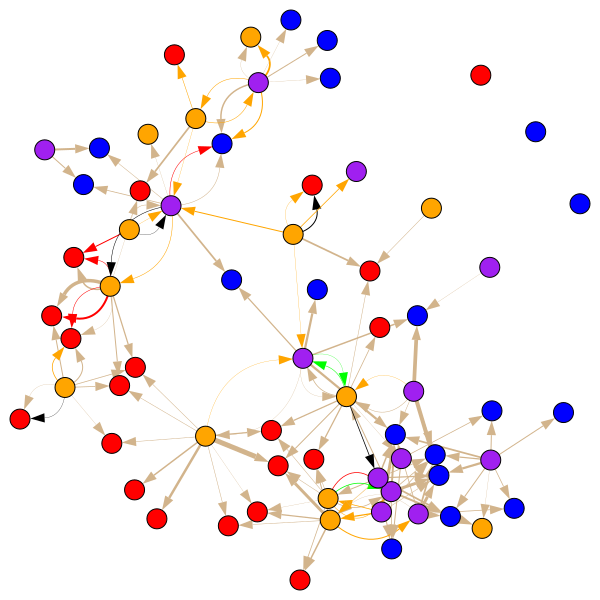

In [189]:
layout = ell.layout("fr")

ig_plot(ell,edge_width = ell.es['weight'],vertex_color=ell.vs['color'],edge_color=ell.es['color'],
       layout=layout)

In [130]:
vertex_color=['blue' if ell.vs['cell_type'] == 'mg1']

SyntaxError: invalid syntax (2532400938.py, line 1)

## create crest files for post-syn segments not in cells

In [14]:
todo_dict= {}
post_segs_without_cell = 0
post_segs_with_cell = 0
for x_pre in ell.vs:
    pre = ecrest(settings_dict,filepath = nodefiles[x_pre['name']],launch_viewer=False)
    
    if pre.cell_data['end_points']['post-synaptic'] != []:

        # for each synapse
        for syn_ in pre.cell_data['end_points']['post-synaptic']:
            post_seg_found=False

            try:
                post_seg = syn_[3]

                # go through each other nodes
                for x_post in ell.vs:

                    post = base_segments[x_post['name']] #ecrest(settings_dict,filepath = nodefiles[x_post['name']],launch_viewer=False)

                    for k,v in post.items():

                        for v_ in list(v): #find keys (can be multiple on the same cell) for matching segment ids

                            if post_seg == v_: 

                            # add edge to the graph between current node and matching node
                                edge_list.append([x_pre['name'],x_post['name'],k])
                                post_seg_found=True
                                if 'mg' in x_pre['cell_type']:
                                    post_segs_with_cell+=1


            except IndexError as msg:
                cellid = x_pre['name']
                print(msg, f'for cell {cellid} synapse at syn_ has no segment id')
            if post_seg_found==False:
                if 'mg' in x_pre['cell_type']:
                    agglo_seg = pre.get_agglo_seg_of_base_seg(post_seg)
                    todo_dict[post_seg] = set(pre.get_base_segs_of_agglo_seg(agglo_seg))
                    post_segs_without_cell+=1

In [15]:
post_segs_without_cell

744

In [16]:
post_segs_with_cell

569

In [17]:
topop=[]

todo_inds = list(todo_dict.keys())
for k,k_ in itertools.combinations(todo_inds,2):
    if todo_dict[k]&todo_dict[k_]!=set():
        # then they share segments
        topop.append(k_)
topop = np.unique(topop)

In [18]:
len(topop)

170

In [19]:
for segid in topop:
    todo_dict.pop(segid)
    

MAKE SURE THESE CELLS DO NOT OVERLAP WITH ALREADY DONE CELLS

In [26]:
topop=[]
        
for todo_k,todo_v in todo_dict.items():
    for base_k, base_v in base_segments.items():
        all_base_v = set([a for b in base_v.values() for a in b])
        
        if set(todo_v) & all_base_v != set():
            # then the cell to do actually already exists in the mg_network... that cell is just missing segments!
            topop.append(todo_k)
            print(f'already have this cell as {base_k}; so that cell must be missing segment {todo_k}')
        # if set(todo_segs) & all_segs_base == set():
            
topop = np.unique(topop)            

already have this cell as 472051969; so that cell must be missing segment 215495298
already have this cell as 213605530; so that cell must be missing segment 299452572
already have this cell as 213605530; so that cell must be missing segment 388917026
already have this cell as 305332461; so that cell must be missing segment 125582740
already have this cell as 307591597; so that cell must be missing segment 306463000
already have this cell as 213669553; so that cell must be missing segment 565183253
already have this cell as 472051969; so that cell must be missing segment 388483828
already have this cell as 300210608; so that cell must be missing segment 307080560
already have this cell as 42800051; so that cell must be missing segment 50585461
already have this cell as 220213102; so that cell must be missing segment 221374661
already have this cell as 30117125; so that cell must be missing segment 217984109
already have this cell as 215526370; so that cell must be missing segment 22012

In [27]:
len(topop)

26

In [29]:
for segid in topop:
    todo_dict.pop(segid)
    

create crest files for each of the unidentified post-synaptic partners

In [31]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

In [32]:


for segment_id in sorted(list(todo_dict.keys())):

    cell = ecrest(settings_dict,segment_id = segment_id, launch_viewer=False)
    cell.save_cell_graph()

Creating base segment graph for cell 101585973 Cell Reconstruction
all base locations for 1700 obtained from SQL database
graph created among all_base_segs
1 clusters of connected components. Connecting these clusters with nearest base segments.
weak clusters connected
segments without a location connected
1 clusters in graph (note should/would be only 1 if loaded base ID from agglomo fresh)
Created a CREST instance for NEW Reconstruction of 101585973. No file saved yet -- save manually.
Saved cell 101585973 reconstruction locally at 2023-04-09 19.21.15
Creating base segment graph for cell 126217026 Cell Reconstruction
all base locations for 1629 obtained from SQL database
graph created among all_base_segs
1 clusters of connected components. Connecting these clusters with nearest base segments.
weak clusters connected
segments without a location connected
1 clusters in graph (note should/would be only 1 if loaded base ID from agglomo fresh)
Created a CREST instance for NEW Reconstructi

check out the cells...
after completing one, make sure to check that it is not one of the currenlty "undone cells"

load one of the cells

In [275]:
filename = 'cell_graph_128473437__2023-04-07 19.33.39.json'
todo_cell = ecrest(settings_dict,filepath = Path(settings_dict['save_dir'])/filename,launch_viewer=True)



updating viewer status message: Current Base Segment Counts: unknown: 966, axon: 161, basal dendrite: 105, apical dendrite: 733, dendrite: 0, multiple: 9


In [270]:
todo_cell.define_ctype('lf','manual')
todo_cell.get_ctype('manual')

'mg2'

In [271]:
todo_cell.save_cell_graph()

Saved cell 128473437 reconstruction locally at 2023-04-08 06.08.54


In [258]:
todo_cell.cell_data['metadata']

{'main_seg': {'agglo': {'brainmaps://10393113184:ell:roi450um_seg32fb16fb_220930:v230111c_16_strict_only_spl': '45057587'},
  'base': '472114046'},
 'data_sources': {'em': 'brainmaps://10393113184:ell:roi450um_xyz',
  'base': 'brainmaps://10393113184:ell:roi450um_seg32fb16fb_220930',
  'agglo': 'brainmaps://10393113184:ell:roi450um_seg32fb16fb_220930:v230111c_16_strict_only_spl'},
 'timing': [],
 'completion': [],
 'cell-type': {'manual': [], 'auto': []},
 'old-anchor': ['302559454']}

379 other base segments in the agglo segment; max number can add is 1000
Added 379 base segments from agglomerated segment 51850046, linked base segments 391933143 and 136613253, 7901nm apart, 
2 base segments removed from 2 connected components
1 base segments removed from 1 connected components
1 base segments removed from 1 connected components
1 base segments removed from 1 connected components
1 base segments removed from 1 connected components
262 base segments removed from 2 connected components
1 other base segments in the agglo segment; max number can add is 1000
Added 1 base segments from agglomerated segment 646137862, linked base segments 646137527 and 646137862, 2285nm apart, 
1 other base segments in the agglo segment; max number can add is 1000
Added 1 base segments from agglomerated segment 646138530, linked base segments 646137862 and 646138530, 3245nm apart, 
1 other base segments in the agglo segment; max number can add is 1000
Added 1 base segments from agglomerated

### Check to make sure this cell is not already on the high priority sheet as "undone"

In [247]:
all_segs = [a for b in todo_cell.cell_data['base_segments'].values() for a in b]

In [248]:
# if it is actually a new cell, this should return an empty set
set(all_segs)&set(undone)

set()

## GET most recent files (by filename date) in folder

In [ ]:
dirname = 'C:/Users/mpetkova/Dropbox/U19_zebrafish/EMfullres/LateralLineCurlDetector/CREST/right_afferents/'
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'C:/Users/EngertLab/Dropbox/CREST/mariela_fish_credentials.json'

names = os.listdir(dirname);
cellid_filename=list();
for ind in range(len(names)):
    content = names[ind].split('_')
    if ('cell' in content):
        cellid_filename.append(names[ind])
d={}
for name in cellid_filename:
    ID,content_type,date=name.split('_')[2], name.split('_')[0], name.split('_')[-1]
    date=date[:-5]
    #create entry in dict which holds ID, file type (ex: cell_graph) and file path
    if ID not in d:
        d[ID]=[date, name]
        #if there are multiple files with the same ID, keep the info for the newest one
    else:
        if date>d[ID][0]:
            d[ID][0]=date
            d[ID][1]=name
            
############################################################################################################################ 
# Collect all the base segments for each ID
import json

base_segs = {}

for key in d.keys():
    f = open(dirname+d[key][1])
    data = json.load(f)
    base_segs[key]=sum(data['base_segments'].values(),[])
    f.close()

############################################################################################################################ 


## Fix cell_data dictionary keys


In [90]:
filepath = Path("/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/")
filepath = filepath / "cell_graph_305332461__2023-04-01 21.04.03.json"

In [91]:
cell = ecrest(settings_dict,filepath = filepath,launch_viewer=False)

In [92]:
old_points = cell.cell_data['end_points']
old_points

{'exit volume': [],
 'natural': [],
 'bad alignment': [],
 'uncorrected split': [],
 'artefact': [],
 'natural end': [],
 'uncertain': [],
 'pre-synaptic': [],
 'post-synaptic': []}

In [93]:
end_points = {}
for p in cell.point_types:
    # if p not in cell.cell_data['end_points']:
    end_points[p] = []
        
cell.cell_data['end_points'] = end_points

In [66]:
cell.cell_data['end_points']['natural end'] = old_points['natural']

In [94]:
# cell.cell_data['end_points'].pop('natural')
cell.cell_data['end_points'].keys()

dict_keys(['exit volume', 'natural end', 'uncertain', 'pre-synaptic', 'post-synaptic'])

In [95]:
cell.save_cell_graph(directory_path = filepath.parent, file_name=filepath.name, save_to_cloud=False); #rewrites the original, not with a new time stamp

Saved cell 305332461 reconstruction locally at 2023-04-05 11.20.24


## Figure out what is wrong with a crest file

In [125]:
filepath = Path("/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/")
filepath = filepath / "cell_graph_213605530__2023-03-29 22.49.21.json"
cell = ecrest(settings_dict,filepath = filepath,launch_viewer=False)

In [127]:
cell.cell_data['end_points']['post-synaptic']

[]

## Fix pre-synaptic to be post-synaptic annotation list in converted crest jsons

In [157]:
json_fix = Path("/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/Complete/synapses/to-crest/conversion_specs_synapse_fix.json")

with open(json_fix,'r') as f:
    cells_to_fix = f.read()
    cells_to_fix = json.loads(cells_to_fix)

In [158]:
cells_to_fix = cells_to_fix['cell_info']

In [163]:
for k,v in cells_to_fix.items():
    try:
        filepath = nodefiles[k]
        cell = ecrest(settings_dict,filepath = filepath,launch_viewer=False)
        cell.cell_data['end_points']['post-synaptic'] = deepcopy(cell.cell_data['end_points']['pre-synaptic'])

        cell.cell_data['end_points']['pre-synaptic'] = []
        # cell.save_cell_graph(directory_path = filepath.parent / 'original', file_name=filepath.name, save_to_cloud=False); #rewrites the original, not with a new time stamp
    except KeyError as msg:
        print(msg)
        continue
        

Saved cell 214412684 reconstruction locally at 2023-04-05 12.11.10
Saved cell 214550811 reconstruction locally at 2023-04-05 12.11.10
Saved cell 215572949 reconstruction locally at 2023-04-05 12.11.10
Saved cell 216129202 reconstruction locally at 2023-04-05 12.11.10
Saved cell 220275752 reconstruction locally at 2023-04-05 12.11.10
Saved cell 297178666 reconstruction locally at 2023-04-05 12.11.10
Saved cell 299497999 reconstruction locally at 2023-04-05 12.11.10
Saved cell 299589324 reconstruction locally at 2023-04-05 12.11.10
Saved cell 300210608 reconstruction locally at 2023-04-05 12.11.10
Saved cell 300316308 reconstruction locally at 2023-04-05 12.11.10
Saved cell 300380579 reconstruction locally at 2023-04-05 12.11.10
"305035439'"
Saved cell 31102601 reconstruction locally at 2023-04-05 12.11.10
Saved cell 387368998 reconstruction locally at 2023-04-05 12.11.10
Saved cell 392213717 reconstruction locally at 2023-04-05 12.11.10
Saved cell 42802314 reconstruction locally at 2023

In [150]:
cell.cell_data['end_points']

{'exit volume': [],
 'natural end': [[142609.46875, 275542.6875, 45.0],
  [142776.15625, 278173.6875, 2775.0],
  [53208.87890625, 271123.09375, 13365.0],
  [70813.0859375, 267435.34375, 10044.652404785156],
  [51008.359375, 284277.96875, 56675.0830078125],
  [68367.4921875, 273829.5625, 31418.91357421875],
  [64639.48046875, 274508.65625, 35085.003662109375],
  [62399.1796875, 303022.0625, 106049.47265625],
  [54059.69921875, 292912.375, 77115.0],
  [115337.7109375, 289251.84375, 74204.99267578125],
  [140118.015625, 284278.375, 106005.0],
  [142204.484375, 284977.09375, 106005.0],
  [111865.0390625, 291143.6875, 67154.99267578125],
  [110964.0390625, 289608.1875, 66825.0],
  [109141.9609375, 289524.5625, 66975.0],
  [106861.765625, 289384.875, 68985.0],
  [222726.3125, 265308.8125, 60494.996337890625],
  [185022.09375, 273914.90625, 45135.0],
  [184830.203125, 272752.84375, 52605.0],
  [169899.09375, 265474.03125, 13754.999084472656],
  [135296.546875, 277537.78125, 40934.996337890625

## Anatomical Clustering